In [139]:
import pandas as pd
import shutil
import numpy as np
import skbio
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
from matplotlib import rcParams
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
#from statsmodels.stats.multicomp import MultiComparison
#dunns
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings

import plotly.express as px
import plotly.graph_objects as go
import os
import re
from plotly.subplots import make_subplots

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm

import statsmodels.api as sa
import scikit_posthocs as sp

from pingouin import kruskal

from statannot import add_stat_annotation

rcParams.update({'figure.autolayout': True})

In [140]:
# date1 = '11.3.21'
# date2 = '18.3.21'
# finaldate = '11.3.21+18.3.21'

In [141]:
# if not os.path.exists(f'../../../../data/plots/luminescence/{finaldate}'):
#     os.mkdir(f'../../../../data/plots/luminescence/{finaldate}')

In [142]:
# if not os.path.exists(f'../../../../data/luminescence/to_be_sorted/{finaldate}'):
#     os.mkdir(f'../../../../data/luminescence/to_be_sorted/{finaldate}')

In [143]:
# #copy files to new folder
# src1 = f'../../../../data/luminescence/to_be_sorted/{date1}/output_raw.csv'
# dst1 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date1}.csv'
# src2 = f'../../../../data/luminescence/to_be_sorted/{date2}/output_raw.csv'
# dst2 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date2}.csv'
# shutil.copyfile(src1,dst1)
# shutil.copyfile(src2,dst2)

In [144]:
def add_promoter_column(df,promoter_number,promoter):
    df.loc[df.name.str.match(fr'(^{promoter_number}.*)')==True, 'Promoter'] = promoter
    

In [145]:
#add TF coexpression column
def add_tf_column(df, TF_number, TF):
    """function to add TF added column based on an input df, a TF_number and a TF name"""
    df.loc[df.name.str.contains(fr'.*{TF_number}.*')&df.TF_added.isnull()==True, 'TF_added'] = TF
    for index, value in df.loc[df.name.str.contains(fr'.*{TF_number}.*')&df.TF_added.notnull()].TF_added.items():
        if re.match(fr'.*{TF}.*', value):
            pass
        else:
            df.iloc[index, df.columns.get_loc('TF_added')] = f'{value}+{TF}'


In [146]:
# #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
# def batch_correction(df,calibrator_promoter_name):
#    #print(df[df.Promoter==calibrator_promoter_name])
#     calibrator = df[df.Promoter==calibrator_promoter_name]
#     calibrator_mean = calibrator['nluc/fluc'].mean(axis=0)
#     df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [147]:
def add_wellcalibrator_column(df,calibrator_code,calibrator):
    #if ends with calibrator_code, change well calibrator column value to the well calibrator name
    df.loc[df.name.str.contains(fr'.*{calibrator_code}$')==True, 'Well_calibrator'] = calibrator

In [148]:
def batch_correction(df,calibrator_promoter_name):
   #print(df[df.Promoter==calibrator_promoter_name])
    calibrator = df[df.Promoter==calibrator_promoter_name]
    print(calibrator)
    #make sure the condition is "calibrator"
    calibrator = calibrator[calibrator.condition=='calibrator']
    print(calibrator)
    #exclude the NAA condition
    #calibrator_no_NAA = calibrator[calibrator.condition=='nitrogen']
    #exclude added TFs or YFP
    calibrator_no_TFs = calibrator[calibrator.TF_added=='No TF nor YFP']
    calibrator_mean = calibrator_no_TFs['nluc/fluc'].mean(axis=0)
    df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [149]:
# def batch_correction(df,calibrator_promoter_name):
#    #print(df[df.Promoter==calibrator_promoter_name])
#     calibrator = df[df.Promoter==calibrator_promoter_name]
#     calibrator_no_NAA = calibrator[calibrator.condition=='nitrogen']
#     calibrator_mean = calibrator_no_NAA['nluc/fluc'].mean(axis=0)
#     df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [150]:
def combine_plates(plate_dict, date):
    """combine the dfs of the plates in the plate dict"""
    for plate_number,plate_df in plate_dict.items():
        #define plate location
        file_location = f'../../../../data/luminescence/to_be_sorted/{date}/plate{plate_number}_output_raw.csv'
        #read in the plate
        plate_df = pd.read_csv(file_location, header=0)
        #add promoters to plate df
        add_promoter_column(plate_df, '14', 'ANAC032')
        add_promoter_column(plate_df, '16', 'ANR1')
        add_promoter_column(plate_df, '18', 'ARF18')
        add_promoter_column(plate_df, '20', 'NLP6')
        add_promoter_column(plate_df, '22', 'DREB26')
        add_promoter_column(plate_df, '24', 'NLP7')
        add_promoter_column(plate_df, '25', 'NIR1')
        add_promoter_column(plate_df, '35', 'NOS')
        add_promoter_column(plate_df, '36', 'STAP4')
        add_promoter_column(plate_df, '70', '35s')
        add_promoter_column(plate_df, '102', 'minimal_STAP4')
        add_promoter_column(plate_df, '103', '1xANR1')
        add_promoter_column(plate_df, '104', '1xNLP7')
        add_promoter_column(plate_df, '105', '1xTCP20+NLP7')
        add_promoter_column(plate_df, '106', '4xANR1')
        add_promoter_column(plate_df, '107', '4xNLP7')
        add_promoter_column(plate_df, '108', '4xTCP20+NLP7')
        add_promoter_column(plate_df, '109', '4xNRE')
        add_promoter_column(plate_df, '71', 'UBQ10')
        add_promoter_column(plate_df, '372', '4x[NRE-TATA]')
        add_promoter_column(plate_df, '373', '4x[NRE-TATA]+spacing')
        add_promoter_column(plate_df, '374', '4x[NRE-random]')
        add_promoter_column(plate_df, '375', '4x[NRE-random]+spacing')
        add_promoter_column(plate_df, '376', '3xHHO2-minsyn_105')
        add_promoter_column(plate_df, '377', 'minsyn_105-3xHHO2')
        add_promoter_column(plate_df, '378', '4x[bZIP3-random]')
        add_promoter_column(plate_df, '379', '4x[TGA1-random]')
        add_promoter_column(plate_df, '380', '2x[bZIP3-random-NRE-random]')
        add_promoter_column(plate_df, '381', '2x[TGA1-random-NRE-random]')
        add_promoter_column(plate_df, '92', 'NRP')
        add_promoter_column(plate_df, 'OZ223', 'NRP:NLUC:YFP')
        add_promoter_column(plate_df, 'OZ224', 'NIR1:NLUC:YFP')
        add_promoter_column(plate_df, 'OZ225', '35s:NLUC:YFP')
        add_promoter_column(plate_df, '491', '4x[NRE-TATA]+spacing:NLUC:YFP')
        add_promoter_column(plate_df, '492', '4x[bZIP3-random]:NLUC:YFP')
        add_promoter_column(plate_df, 'OZ115', '35s:NLUC:YFP_nomarker')

        

        #add TF column to date1 df
        plate_df['TF_added'] = np.nan
        add_tf_column(plate_df,'27','NLP6')
        add_tf_column(plate_df,'29','NLP7')
        add_tf_column(plate_df,'30','DREB26')
        add_tf_column(plate_df,'31','ANAC032')
        add_tf_column(plate_df,'32','ARF18')
        add_tf_column(plate_df,'33','ANR1')
        add_tf_column(plate_df,'111','TCP20')
        add_tf_column(plate_df,'348','HHO2')
        add_tf_column(plate_df,'349','bZIP3')
        add_tf_column(plate_df,'351','TGA1')
        add_tf_column(plate_df,'113','ARF9')
        add_tf_column(plate_df,'YFP','No TF')
        add_tf_column(plate_df,'IAA','IAA33')
        add_tf_column(plate_df,'355','dCas9_activator1')
        add_tf_column(plate_df,'356','dCas9_activator2')
        add_tf_column(plate_df,'357','dCas9_activator3')
        add_tf_column(plate_df,'362','dCpf1_repressor1')
        add_tf_column(plate_df,'363','dCpf1_repressor2')
        add_tf_column(plate_df,'364','dCpf1_repressor3')
        add_tf_column(plate_df,'411','UBQ10_dCas9_activator_123guides')
        add_tf_column(plate_df,'438','UBQ10_dCpf1_repressor1')
        add_tf_column(plate_df,'439','UBQ10_dCpf1_repressor2')
        add_tf_column(plate_df,'440','UBQ10_dCpf1_repressor3')
        add_tf_column(plate_df,'441','UBQ10_dCpf1_repressor123guides')
        add_tf_column(plate_df,'464','UBQ10_dCas9_activator')
        add_tf_column(plate_df,'404','guide1')
        add_tf_column(plate_df,'473','UBQ10_dCas9_repressor_guide3')
        add_tf_column(plate_df,'405','guide2')

        #add well calibrator column
        add_wellcalibrator_column(plate_df, 'YC003', 'NOS_LucF')
        add_wellcalibrator_column(plate_df, '34', '35s_LucF')

        #add plate number column
        plate_df['Plate_number'] = plate_number

        #Change TF_added NaN values to none
        plate_df.loc[plate_df.TF_added.isnull()==True, 'TF_added'] = 'No TF nor YFP'

        #Change condition NaN values to nitrogen
        plate_df.loc[plate_df.condition.isnull()==True, 'condition'] = 'nitrogen'

        #Change Well_calibrator NaN values to unknown
        plate_df.loc[plate_df.Well_calibrator.isnull()==True, 'Well_calibrator'] = 'unknown'

        #add plate df to dictionary
        plate_dict[plate_number] = plate_df
        
        #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
        batch_correction(plate_df, 'NOS')
        
        #if NAA condition, add that name to the TF name
        plate_df.loc[plate_df['condition'].str.contains('1uM_auxin'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains('1uM_auxin'), 'TF_added'] + '_1μM_NAA'
        #if calibrator, add to the promoter name
        plate_df.loc[plate_df['condition'].str.contains('calibrator'),'Promoter' ] = plate_df.loc[plate_df['condition'].str.contains('calibrator'),'Promoter' ] + '_calibrator'
        #if well calibrator, add to the promoter
        # plate_df.loc[plate_df['Well_calibrator'].str.contains('NOS_LucF'),'TF_added' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('NOS_LucF'), 'TF_added'] + '_NOS:LucF_calibrator'
        # plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'TF_added' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'), 'TF_added'] + '_35s:LucF_calibrator'
        plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'Promoter' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'Promoter' ] + '_35s:LucF_calibrator'
        
        
        

    #merge the dfs with different dates
    luminescence_raw_df = pd.concat(plate_dict.values(), ignore_index=True)
    # luminescence_raw_df_plate1 = plate_dict[1]
    # luminescence_raw_df_plate2 = plate_dict[2]
    # luminescence_raw_df_plate3 = plate_dict[3]
    # luminescence_raw_df_plate4 = plate_dict[4]
    # luminescence_raw_df_plate5 = plate_dict[5]
    # luminescence_raw_df_plate6 = plate_dict[6]
    # luminescence_raw_df_plate7 = plate_dict[7]
    # luminescence_raw_df_plate8 = plate_dict[8]
    # #Change TF_added NaN values to none
    # luminescence_raw_df_plate1.loc[luminescence_raw_df_plate1.TF_added.isnull()==True, 'TF_added'] = 'No TF'
    # luminescence_raw_df_plate2.loc[luminescence_raw_df_plate2.TF_added.isnull()==True, 'TF_added'] = 'No TF'

    
    

    #sort rows by the custom promoter order I want so plots are in the correct order
    #sort rows by the custom promoter order I want so plots are in the correct order
    # luminescence_raw_df_plate1.Promoter = pd.Categorical(luminescence_raw_df_plate1.Promoter,
    #                                           ['YFP','NOS','NOS_calibrator','minimal_STAP4','UBQ10','NRP','4xNRE','4x[NRE-TATA]','4x[NRE-TATA]+spacing','4x[NRE-random]','4x[NRE-random]+spacing','3xHHO2-minsyn_105','minsyn_105-3xHHO2','4x[bZIP3-random]','2x[bZIP3-random-NRE-random]','4x[TGA1-random]','2x[TGA1-random-NRE-random]'])
    # luminescence_raw_df_plate1 = luminescence_raw_df_plate1.sort_values("Promoter")

    # luminescence_raw_df_plate2.Promoter = pd.Categorical(luminescence_raw_df_plate2.Promoter,
    #                                           ['YFP','NOS','NOS_calibrator','STAP4','35s','ANAC032','ANR1','ARF18','DREB26','NIR1','NLP6', 'NLP7'])
    # luminescence_raw_df_plate2 = luminescence_raw_df_plate2.sort_values("Promoter")
    luminescence_raw_df.Promoter = pd.Categorical(luminescence_raw_df.Promoter,
                                              ['NOS','NOS_calibrator','STAP4','35s','ANAC032','ANR1','ARF18','DREB26','NIR1','NLP6', 'NLP7','NOS_35s:LucF_calibrator','NOS_calibrator_35s:LucF_calibrator','STAP4_35s:LucF_calibrator','35s_35s:LucF_calibrator','ANAC032_35s:LucF_calibrator','ANR1_35s:LucF_calibrator','ARF18_35s:LucF_calibrator','DREB26_35s:LucF_calibrator','NIR1_35s:LucF_calibrator','NLP6_35s:LucF_calibrator', 'NLP7_35s:LucF_calibrator','NRP','NRP_35s:LucF_calibrator','NRP:NLUC:YFP','NIR1:NLUC:YFP','35s:NLUC:YFP','35s:NLUC:YFP_nomarker','4x[NRE-TATA]+spacing:NLUC:YFP','4x[NRE-TATA]+spacing:NLUC:YFP_35s:LucF_calibrator','4x[bZIP3-random]:NLUC:YFP','NRP:NLUC:YFP_35s:LucF_calibrator','NIR1:NLUC:YFP_35s:LucF_calibrator'])
    luminescence_raw_df = luminescence_raw_df.sort_values("Promoter")

    
    #save as file
    # location1 = f'../../../../data/luminescence/to_be_sorted/{date}/output_plate1.tsv'
    # location2 = f'../../../../data/luminescence/to_be_sorted/{date}/output_plate2.tsv'
    location = f'../../../../data/luminescence/to_be_sorted/{date}/combined_output.tsv'

    luminescence_raw_df.to_csv(location,sep='\t',header=True)

    # luminescence_raw_df_plate1.to_csv(location1,sep='\t',header=True)
    # luminescence_raw_df_plate2.to_csv(location2,sep='\t',header=True)
    
    return luminescence_raw_df

In [151]:
# def combine_plates(plate_dict, date):
#     """combine the dfs of the plates in the plate dict"""
#     for plate_number,plate_df in plate_dict.items():
#         #define plate location
#         file_location = f'../../../../data/luminescence/to_be_sorted/{date}/plate{plate_number}_output_raw.csv'
#         #read in the plate
#         plate_df = pd.read_csv(file_location, header=0)
#         #add promoters to plate df
#         add_promoter_column(plate_df, '14', 'ANAC032')
#         add_promoter_column(plate_df, '16', 'ANR1')
#         add_promoter_column(plate_df, '18', 'ARF18')
#         add_promoter_column(plate_df, '20', 'NLP6')
#         add_promoter_column(plate_df, '22', 'DREB26')
#         add_promoter_column(plate_df, '24', 'NLP7')
#         add_promoter_column(plate_df, '25', 'NIR1')
#         add_promoter_column(plate_df, '35', 'NOS')
#         add_promoter_column(plate_df, '36', 'STAP4')
#         add_promoter_column(plate_df, '70', '35s')
#         add_promoter_column(plate_df, '102', 'minimal_STAP4')
#         add_promoter_column(plate_df, '103', '1xANR1')
#         add_promoter_column(plate_df, '104', '1xNLP7')
#         add_promoter_column(plate_df, '105', '1xTCP20+NLP7')
#         add_promoter_column(plate_df, '106', '4xANR1')
#         add_promoter_column(plate_df, '107', '4xNLP7')
#         add_promoter_column(plate_df, '108', '4xTCP20+NLP7')
#         add_promoter_column(plate_df, '109', '4xNRE')
#         add_promoter_column(plate_df, '71', 'UBQ10')
#         add_promoter_column(plate_df, '372', '4x[NRE-TATA]')
#         add_promoter_column(plate_df, '373', '4x[NRE-TATA]+spacing')
#         add_promoter_column(plate_df, '374', '4x[NRE-random]')
#         add_promoter_column(plate_df, '375', '4x[NRE-random]+spacing')
#         add_promoter_column(plate_df, '376', '3xHHO2-minsyn_105')
#         add_promoter_column(plate_df, '377', 'minsyn_105-3xHHO2')
#         add_promoter_column(plate_df, '378', '4x[bZIP3-random]')
#         add_promoter_column(plate_df, '379', '4x[TGA1-random]')
#         add_promoter_column(plate_df, '380', '2x[bZIP3-random-NRE-random]')
#         add_promoter_column(plate_df, '381', '2x[TGA1-random-NRE-random]')

#         #add TF column to date1 df
#         plate_df['TF_added'] = np.nan
#         add_tf_column(plate_df,'27','NLP6')
#         add_tf_column(plate_df,'29','NLP7')
#         add_tf_column(plate_df,'30','DREB26')
#         add_tf_column(plate_df,'31','ANAC032')
#         add_tf_column(plate_df,'32','ARF18')
#         add_tf_column(plate_df,'33','ANR1')
#         add_tf_column(plate_df,'111','TCP20')
#         add_tf_column(plate_df,'348','HHO2')
#         add_tf_column(plate_df,'349','bZIP3')
#         add_tf_column(plate_df,'351','TGA1')
#         add_tf_column(plate_df,'113','ARF9')

#         #Change TF_added NaN values to none
#         plate_df.loc[plate_df.TF_added.isnull()==True, 'TF_added'] = 'No TF'

#         #Change condition NaN values to nitrogen
#         plate_df.loc[plate_df.condition.isnull()==True, 'condition'] = 'nitrogen'

#         #add plate df to dictionary
#         plate_dict[plate_number] = plate_df
        
#         #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
#         batch_correction(plate_df, 'NOS')

#     #merge the dfs with different dates
#     luminescence_raw_df = pd.concat(plate_dict.values(), ignore_index=True)

#     #Change TF_added NaN values to none
#     luminescence_raw_df.loc[luminescence_raw_df.TF_added.isnull()==True, 'TF_added'] = 'No TF'
    
#     #if NAA condition, add that name to the TF name
#     luminescence_raw_df.loc[luminescence_raw_df['condition'].str.contains('1uM_auxin'),'TF_added' ] = luminescence_raw_df.loc[luminescence_raw_df['condition'].str.contains('1uM_auxin'), 'TF_added'] + '_1μM_NAA'

#     #sort rows by the custom promoter order I want so plots are in the correct order
#     luminescence_raw_df.Promoter = pd.Categorical(luminescence_raw_df.Promoter,
#                                               ['NOS','STAP4','35s','ANAC032','ANR1','ARF18','DREB26','NIR1','NLP6', 'NLP7'])
#     luminescence_raw_df = luminescence_raw_df.sort_values('Promoter')
 

    
#     #save as file
#     location = f'../../../../data/luminescence/to_be_sorted/{date}/combined_output.tsv'

#     luminescence_raw_df.to_csv(location,sep='\t',header=True)
    
#     return luminescence_raw_df

In [152]:
#first creat a dict of plate numbers and plate dfs
#first create empty variables
luminescence_raw_df_plate1 = ""
luminescence_raw_df_plate2 = ""
luminescence_raw_df_plate3 = ""
luminescence_raw_df_plate4 = ""
plate_dict = {1:luminescence_raw_df_plate1, 2:luminescence_raw_df_plate2, 3:luminescence_raw_df_plate3, 4:luminescence_raw_df_plate4}

In [153]:
#combine plates
date = '11.8.21'
luminescence_raw_df = combine_plates(plate_dict, date)

   well     content  fluc_luminescence  nluc_luminescence well_row  well_col  \
54  E10  Sample X82            33310.0          2269855.0        E        10   
55  E11  Sample X83            32162.0          2640822.0        E        11   
56  E12  Sample X84            32214.0          2333930.0        E        12   

     name   condition  nluc/fluc     date Promoter       TF_added  \
54  35+34  calibrator  68.143350  11.8.21      NOS  No TF nor YFP   
55  35+34  calibrator  82.110006  11.8.21      NOS  No TF nor YFP   
56  35+34  calibrator  72.450798  11.8.21      NOS  No TF nor YFP   

   Well_calibrator  Plate_number  
54        35s_LucF             1  
55        35s_LucF             1  
56        35s_LucF             1  
   well     content  fluc_luminescence  nluc_luminescence well_row  well_col  \
54  E10  Sample X82            33310.0          2269855.0        E        10   
55  E11  Sample X83            32162.0          2640822.0        E        11   
56  E12  Sample X84   

In [154]:
luminescence_raw_df

,well,content,fluc_luminescence,nluc_luminescence,well_row,well_col,name,condition,nluc/fluc,date,Promoter,TF_added,Well_calibrator,Plate_number,corrected_luminescence
153,F10,Sample X78,26962.0,2548980.0,F,10,35+34,calibrator,94.539723,11.8.21,NOS_calibrator_35s:LucF_calibrator,No TF nor YFP,35s_LucF,2,99.364976
154,F11,Sample X84,25462.0,2415656.0,F,11,35+34,calibrator,94.872987,11.8.21,NOS_calibrator_35s:LucF_calibrator,No TF nor YFP,35s_LucF,2,99.715251
320,E11,Sample X81,27292.0,2603331.0,E,11,35+34,calibrator,95.388062,11.8.21,NOS_calibrator_35s:LucF_calibrator,No TF nor YFP,35s_LucF,4,98.825899
54,E10,Sample X82,33310.0,2269855.0,E,10,35+34,calibrator,68.143350,11.8.21,NOS_calibrator_35s:LucF_calibrator,No TF nor YFP,35s_LucF,1,91.794449
55,E11,Sample X83,32162.0,2640822.0,E,11,35+34,calibrator,82.110006,11.8.21,NOS_calibrator_35s:LucF_calibrator,No TF nor YFP,35s_LucF,1,110.608632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,D11,Sample X83,407584.0,770600.0,D,11,24+348+34,nitrogen,1.890653,11.8.21,NLP7_35s:LucF_calibrator,HHO2,35s_LucF,3,1.442606
221,D12,Sample X90,405383.0,764945.0,D,12,24+348+34,nitrogen,1.886969,11.8.21,NLP7_35s:LucF_calibrator,HHO2,35s_LucF,3,1.439794
228,E07,Sample X53,31408.0,175061.0,E,7,24+113+34,1uM_auxin,5.573771,11.8.21,NLP7_35s:LucF_calibrator,ARF9_1μM_NAA,35s_LucF,3,4.252898
207,C10,Sample X75,284591.0,1537341.0,C,10,24+33+34,nitrogen,5.401931,11.8.21,NLP7_35s:LucF_calibrator,ANR1,35s_LucF,3,4.121781


In [155]:
# luminescence_raw_df_renamed = luminescence_raw_df.copy()
# luminescence_raw_df_renamed.gene_type.replace('DREB26+ARF18','+DREB26+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('ARF18','+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('randCont','random', inplace=True)


In [156]:
#get TF names
pd.Categorical(luminescence_raw_df.TF_added)
names = luminescence_raw_df.TF_added.unique()
#Change TF names to +TF
luminescence_raw_df_renamed = luminescence_raw_df.copy()
for TF in names:
    if TF != 'No TF':
        luminescence_raw_df_renamed.TF_added.replace(TF,f'+{TF}', inplace=True)
luminescence_raw_df = luminescence_raw_df_renamed

In [157]:
# #change order
# def sorter(column):
#     order = ['No TF','+No TF_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
#     cat = pd.Categorical(column, categories=order, ordered=True)
#     return pd.Series(cat)
# luminescence_raw_df = luminescence_raw_df.sort_values(by='TF_added', key=sorter)

### get names of each TF_added for later

In [158]:
pd.Categorical(luminescence_raw_df.TF_added)
names = luminescence_raw_df.TF_added.unique()
for name in names:
    print(name)

+No TF nor YFP
+ARF18+ARF9_1μM_NAA
+ANAC032
+ARF18
+NLP7
+DREB26
+NLP6
+No TF nor YFP_1μM_NAA
+ARF18_1μM_NAA
+ARF9_1μM_NAA
+bZIP3
+HHO2
+ARF9
+ARF18+ARF9
+TGA1
+ANR1


In [159]:
#get list of promoters
pd.Categorical(luminescence_raw_df.Promoter)
prom_names = luminescence_raw_df.Promoter.unique()
for name in prom_names:
    print(name)

NOS_calibrator_35s:LucF_calibrator
35s_35s:LucF_calibrator
ANAC032_35s:LucF_calibrator
ANR1_35s:LucF_calibrator
ARF18_35s:LucF_calibrator
DREB26_35s:LucF_calibrator
NIR1_35s:LucF_calibrator
NLP6_35s:LucF_calibrator
NLP7_35s:LucF_calibrator


In [160]:
#create colours
from random import randint
color = []
n = len(names)
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))
print(color)


['#9D5689', '#4E5271', '#1A89AC', '#48838D', '#781739', '#DB554E', '#903315', '#E75FDA', '#DE9DBC', '#3C24AA', '#290E44', '#398ABB', '#448FCD', '#8D336F', '#1BCBC2', '#0CC06A']


In [161]:
#make dictionary with TF_added names as key and the randomly generated colors as values
new_color = dict(zip(names, color))
new_color

{'+No TF nor YFP': '#9D5689',
 '+ARF18+ARF9_1μM_NAA': '#4E5271',
 '+ANAC032': '#1A89AC',
 '+ARF18': '#48838D',
 '+NLP7': '#781739',
 '+DREB26': '#DB554E',
 '+NLP6': '#903315',
 '+No TF nor YFP_1μM_NAA': '#E75FDA',
 '+ARF18_1μM_NAA': '#DE9DBC',
 '+ARF9_1μM_NAA': '#3C24AA',
 '+bZIP3': '#290E44',
 '+HHO2': '#398ABB',
 '+ARF9': '#448FCD',
 '+ARF18+ARF9': '#8D336F',
 '+TGA1': '#1BCBC2',
 '+ANR1': '#0CC06A'}

In [162]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}


# for prom in prom_names:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df[luminescence_raw_df.Promoter == prom].sort_values("TF_added", ascending=False)


#         fig = px.violin(df, x='TF_added',
#                                   y='corrected_luminescence', box=True,                       
#                                 color='TF_added', color_discrete_map=new_color,violinmode='overlay') #points="all"

#         fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#         fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#         fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#         #hide legend
#         fig.layout.update(showlegend=False)
#         #write to file static image and interactive one
#         fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         fig.show()

In [163]:
for TF in names:
    print(TF)

+No TF nor YFP
+ARF18+ARF9_1μM_NAA
+ANAC032
+ARF18
+NLP7
+DREB26
+NLP6
+No TF nor YFP_1μM_NAA
+ARF18_1μM_NAA
+ARF9_1μM_NAA
+bZIP3
+HHO2
+ARF9
+ARF18+ARF9
+TGA1
+ANR1


In [164]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# fig = go.Figure(go.Violin(y=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].corrected_luminescence, x=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].TF_added,
#                           fillcolor='#840122', box_visible=True, meanline_visible=True))
#               #points="all"

# fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
# fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
# fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
# #write to file static image and interactive one
# #fig.write_image(f'../../../../data/plots/luminescence/{date}/violin23.9.19.pdf')
# #fig.write_html(f'../../../../data/plots/luminescence/{date}/violin23.9.19.html')

# fig.show()

In [165]:
def dunn_posthoc_test(df, dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(
        df,
        val_col=dependent_variable,
        group_col=between,
        p_adjust="bonferroni",
    )

In [166]:
#create plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/11.8.21  already exists


In [167]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/exp_design'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/11.8.21/exp_design  already exists


In [168]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_nos'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/11.8.21/exp_design/calibrator_nos  already exists


In [169]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_35s'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/11.8.21/exp_design/calibrator_35s  already exists


In [170]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters 2 Tf categories

# for prom in prom_names:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df[luminescence_raw_df.Promoter == prom].sort_values("TF_added", ascending=False)
#         TFs =  df.TF_added.unique()
#         print(prom)
#         print(TFs)
#         if len(TFs) is not 2:
#             pass
#         else:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#             # change axes labels
#             plt.ylabel('Mean luminescence (a.u.)')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
            
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )           


#         #write to file static image and interactive one
#        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#       #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#       #  fig.show()

In [171]:
luminescence_raw_df_plate1=luminescence_raw_df.copy()

35s_35s:LucF_calibrator
['+ANAC032', '+ANR1', '+ARF9', '+ARF18', '+ARF18+ARF9', '+bZIP3', '+DREB26', '+HHO2', '+NLP6', '+NLP7', '+TGA1']


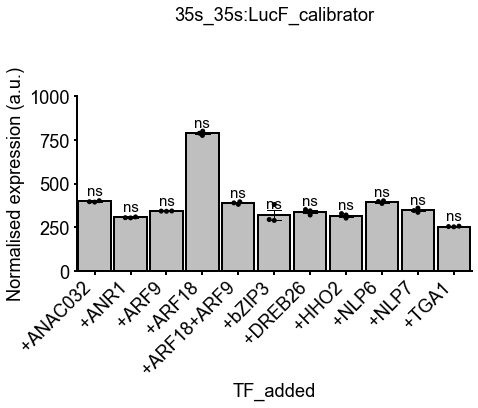

In [172]:
#make experimental design plots other TFs
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
fontsize = 18.25
rcParams['font.size'] = fontsize
#for getting the microsoft font Arial working, please follow this guide: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#allow font to be edited later in pdf editor
rcParams ['pdf.fonttype'] = 42 
#define bar width
bar_width = 0.9
#make svg text editable
rcParams['svg.fonttype'] = 'none'
#align y-axis top most tick with end of axis
rcParams['axes.autolimit_mode'] = 'round_numbers'
#set margins to ensure any error bars fit
rcParams['axes.xmargin'] = 0.2
rcParams['axes.ymargin'] = 0.2

#set width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


for prom in prom_names:
    if prom == 'NOS_calibrator' or prom == 'NOS_calibrator_35s:LucF_calibrator' or prom == 'STAP4' or prom == 'minimal_STAP4':
        pass
    #if 35s calibrator in promoter name, skip promoter
    elif prom == '35s_35s:LucF_calibrator':
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        #df2['TF_added'] = 'pSTAP4 no TF'
        #df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+ANAC032','+ANR1','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
        #new_TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #'No TF/YFP','+No TF/YFP_1μM_NAA',
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "No TF" or TFs[x] == "No TF_1μM_NAA":
                pass
            #if auxin condition, use auxin control
            elif "_1μM_NAA" in TFs[x]:
                box_pairs.append(('No TF_1μM_NAA',TFs[x]))

            else:
                box_pairs.append(('No TF',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))~
        #make box pairs dict with box pair and p value
        box_pairs_all_pvalues = {}
        #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
        TFs_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
            TFs_pvalues[pair[1]] = results.pvalue
            #get mean of each TF in pair
            TF1_mean = TF1.mean()   
            TF2_mean = TF2.mean()
            #get standard deviation of each TF in pair
            TF1_SD = TF1.std()
            TF2_SD = TF2.std()

            with open(f'../../../../data/plots/luminescence/{date}/exp_design/stats.txt', 'a') as f:                       
                f.write(f'{str(prom)},{pair},{results}\nmean of {pair[0]} = {TF1_mean}, mean of {pair[1]} = {TF2_mean}\nSD of {pair[0]} = {TF1_SD}, SD of {pair[1]} = {TF2_SD}\n')
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        #print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v

        def convert_pvalue_to_asterisks(pvalue):
            if pvalue <= 0.001:
                return "***"
            elif pvalue <= 0.01:
                return "**"
            elif pvalue <= 0.05:
                return "*"
            return "ns"
        #print(df.columns)
        #'well', 'content', 'fluc_luminescence', 'nluc_luminescence', 'well_row',
    #    'well_col', 'name', 'condition', 'nluc/fluc', 'date', 'Promoter',
    #    'TF_added', 'Well_calibrator', 'Plate_number',
    #    'corrected_luminescence'
        #add a blank data point in between non-auxin and auxin conditions

        #new_df = pd.concat([df[df.condition == 'nitrogen'], pd.DataFrame({'well':[''],'content':[''],'fluc_luminescence':[0],'nluc_luminescence':[0], 'well_row':[''],'well_col':[0], 'name':[''], 'condition':['nitrogen'], 'nluc/fluc':[0], 'date':[''], 'Promoter':[prom],'TF_added':[''], 'Well_calibrator':[''], 'Plate_number':[0],'corrected_luminescence':[0]}, df[df.condition == '1uM_auxin'])])

        # #rename x values
        # names = df.TF_added.unique()
        # #Change TF names to +TF
        # df_renamed = df.copy()
        # for TF in names:
        #     if '_1μM_NAA' in TF:
        #         new_name = TF[:len(TF)-8]
        #         df_renamed.TF_added.replace(TF,new_name, inplace=True)
        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) == 2:
            #plt.figure()
            plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
            #order_new = [TFs[0],TFs[1]]
            
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4, dodge=True,color='#BFBFBF')#facecolor=(1,1,1,1),

            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,)
            change_width(fig,bar_width)
            #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # label box pairs        
            #box_pairs = [(TFs[0],TFs[1])]
            
            # make empty list of p_values
           # p_values = []
            # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            #     print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            # add_stat_annotation(
            #     fig,
            #     data=df,
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     order=order_new,
            #     box_pairs=list(box_pairs_significant.keys()),
            #     text_format="star",
            #     loc="outside",
            #     verbose=2,
            #     perform_stat_test=False,
            #     pvalues=list(box_pairs_significant.values()),
            #     #test='Mann-Whitney',
            # )
            # # change axes labels
            # plt.ylabel('Normalised expression (a.u.)')
            # #add title
            # plt.title(prom)
            # #make xticks diagonal
            # plt.xticks(rotation=45, ha='right')
            # #plt.xlabel(x_label)
            # # tight layout
            # plt.tight_layout()
            # # save figure
            # plt.savefig(
            #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
            #     format="pdf",
            #     bbox_inches="tight",
           # )
        elif len(TFs) < 2:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,dodge=True, color='#BFBFBF') #facecolor=(1,1,1,1)
           
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True)
            change_width(fig,bar_width)
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
        #add stats
        #print(box_pairs)
        #if no significant values, don't add stats annotation

        


        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     pass
            # #add a gap between no auxin and auxin conditions
            # #first identify No TF_1μM_NAA X position
            # middle = order.index("No TF_1μM_NAA")
            # #then modify x locations with a gap before the auxin no tf position

            # x_locations = list(range(0,middle))+list(range(middle+1,len(order)+1))
            # print(x_locations)
            # plt.xticks(x_locations,order)
            
            #plt.bar_label(box_pairs_all_pvalues.values())
            #get x length
            xlength=len(fig.patches)
            #print(f'xlength={xlength}')
            #add patterned hatching to the bars length_tf
            #hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            #also add asterisks for p values
            #make empty variable to show when No TF_1μM_NAA has been iterated over
            #auxin_control_picked = False
            for x in range (0, (xlength)):
                current_TF = order[x]
                if current_TF == "No TF" or current_TF == '':                
                    pass
                elif current_TF == "No TF_1μM_NAA":
                    auxin_control_picked = True                    
                   # hatch = next(hatches)
                    fig.patches[x].set_hatch(hatch)
                else:
                    pvalue = TFs_pvalues[current_TF]

                    
                # pvalue = list(box_pairs_all_pvalues.values())[x]
                    #key=list(box_pairs_all_pvalues.keys())[x][1]
                    p = fig.patches[x]
                    fig.annotate(convert_pvalue_to_asterisks(pvalue),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=15,
                    xytext = (0, 10), 
                    textcoords = 'offset points')
                    #add patterned hatching to the bars length_tf
                    #if auxin_control_picked == True:
            plt.ylabel('Normalised expression (a.u.)')
            #add title
            plt.title(prom, y=1.4,size=fontsize)
            #make xticks diagonal
            plt.xticks(rotation=45, ha='right')
            #plt.xlabel(x_label)
            # tight layout
            plt.tight_layout()
            # save figure
            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_35s/scatter{prom}_ARFs_plate1.pdf',
                format="pdf",
                bbox_inches="tight",transparent=True)

            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_35s/scatter{prom}_ARFs_plate1.svg',
                format="svg",
                bbox_inches="tight",transparent=True)
        
    elif prom == 'NOS':        
          
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        #df2['TF_added'] = 'pSTAP4 no TF'
        #df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+ANAC032','+ANR1','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
        #new_TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #'No TF/YFP','+No TF/YFP_1μM_NAA',
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "No TF" or TFs[x] == "No TF_1μM_NAA":
                pass
            #if auxin condition, use auxin control
            elif "_1μM_NAA" in TFs[x]:
                box_pairs.append(('No TF_1μM_NAA',TFs[x]))

            else:
                box_pairs.append(('No TF',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))~
        #make box pairs dict with box pair and p value
        box_pairs_all_pvalues = {}
        #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
        TFs_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
            TFs_pvalues[pair[1]] = results.pvalue
            #get mean of each TF in pair
            TF1_mean = TF1.mean()   
            TF2_mean = TF2.mean()
            #get standard deviation of each TF in pair
            TF1_SD = TF1.std()
            TF2_SD = TF2.std()

            with open(f'../../../../data/plots/luminescence/{date}/exp_design/stats.txt', 'a') as f:                       
                f.write(f'{str(prom)},{pair},{results}\nmean of {pair[0]} = {TF1_mean}, mean of {pair[1]} = {TF2_mean}\nSD of {pair[0]} = {TF1_SD}, SD of {pair[1]} = {TF2_SD}\n')
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        #print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v

        def convert_pvalue_to_asterisks(pvalue):
            if pvalue <= 0.001:
                return "***"
            elif pvalue <= 0.01:
                return "**"
            elif pvalue <= 0.05:
                return "*"
            return "ns"
        #print(df.columns)
        #'well', 'content', 'fluc_luminescence', 'nluc_luminescence', 'well_row',
    #    'well_col', 'name', 'condition', 'nluc/fluc', 'date', 'Promoter',
    #    'TF_added', 'Well_calibrator', 'Plate_number',
    #    'corrected_luminescence'
        #add a blank data point in between non-auxin and auxin conditions

        #new_df = pd.concat([df[df.condition == 'nitrogen'], pd.DataFrame({'well':[''],'content':[''],'fluc_luminescence':[0],'nluc_luminescence':[0], 'well_row':[''],'well_col':[0], 'name':[''], 'condition':['nitrogen'], 'nluc/fluc':[0], 'date':[''], 'Promoter':[prom],'TF_added':[''], 'Well_calibrator':[''], 'Plate_number':[0],'corrected_luminescence':[0]}, df[df.condition == '1uM_auxin'])])

        # #rename x values
        # names = df.TF_added.unique()
        # #Change TF names to +TF
        # df_renamed = df.copy()
        # for TF in names:
        #     if '_1μM_NAA' in TF:
        #         new_name = TF[:len(TF)-8]
        #         df_renamed.TF_added.replace(TF,new_name, inplace=True)
        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) == 2:
            #plt.figure()
            plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
            #order_new = [TFs[0],TFs[1]]
            
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4, dodge=True,color='#BFBFBF')#facecolor=(1,1,1,1),

            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,)
            change_width(fig,bar_width)
            #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # label box pairs        
            #box_pairs = [(TFs[0],TFs[1])]
            
            # make empty list of p_values
           # p_values = []
            # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            #     print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            # add_stat_annotation(
            #     fig,
            #     data=df,
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     order=order_new,
            #     box_pairs=list(box_pairs_significant.keys()),
            #     text_format="star",
            #     loc="outside",
            #     verbose=2,
            #     perform_stat_test=False,
            #     pvalues=list(box_pairs_significant.values()),
            #     #test='Mann-Whitney',
            # )
            # # change axes labels
            # plt.ylabel('Normalised expression (a.u.)')
            # #add title
            # plt.title(prom)
            # #make xticks diagonal
            # plt.xticks(rotation=45, ha='right')
            # #plt.xlabel(x_label)
            # # tight layout
            # plt.tight_layout()
            # # save figure
            # plt.savefig(
            #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
            #     format="pdf",
            #     bbox_inches="tight",
           # )
        elif len(TFs) < 2:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,dodge=True,color='#BFBFBF')#facecolor=(1,1,1,1),
           
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True)
            change_width(fig,bar_width)
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
        #add stats
        #print(box_pairs)
        #if no significant values, don't add stats annotation

        


        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     pass
            # #add a gap between no auxin and auxin conditions
            # #first identify No TF_1μM_NAA X position
            # middle = order.index("No TF_1μM_NAA")
            # #then modify x locations with a gap before the auxin no tf position

            # x_locations = list(range(0,middle))+list(range(middle+1,len(order)+1))
            # print(x_locations)
            # plt.xticks(x_locations,order)
            
            #plt.bar_label(box_pairs_all_pvalues.values())
            #get x length
            xlength=len(fig.patches)
            #print(f'xlength={xlength}')
            #add patterned hatching to the bars length_tf
            #hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            #also add asterisks for p values
            #make empty variable to show when No TF_1μM_NAA has been iterated over
            #auxin_control_picked = False
            for x in range (0, (xlength)):
                current_TF = order[x]
                if current_TF == "No TF" or current_TF == '':                
                    pass
                elif current_TF == "No TF_1μM_NAA":
                    auxin_control_picked = True                    
                   # hatch = next(hatches)
                    fig.patches[x].set_hatch(hatch)
                else:
                    pvalue = TFs_pvalues[current_TF]

                    
                # pvalue = list(box_pairs_all_pvalues.values())[x]
                    #key=list(box_pairs_all_pvalues.keys())[x][1]
                    p = fig.patches[x]
                    fig.annotate(convert_pvalue_to_asterisks(pvalue),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=15,
                    xytext = (0, 10), 
                    textcoords = 'offset points')
                    #add patterned hatching to the bars length_tf
                    #if auxin_control_picked == True:
            plt.ylabel('Normalised expression (a.u.)')
            #add title
            plt.title(prom, y=1.4,size=fontsize)
            #make xticks diagonal
            plt.xticks(rotation=45, ha='right')
            #plt.xlabel(x_label)
            # tight layout
            plt.tight_layout()
            # save figure
            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_nos/scatter{prom}_experimental_design_plate1.pdf',
                format="pdf",
                bbox_inches="tight",transparent=True)

            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_nos/scatter{prom}_experimental_design_plate1.svg',
                format="svg",
                bbox_inches="tight",transparent=True)

                           # p.set_hatch(hatch)
             
            # hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            # for i, bar in enumerate(fig.patches):
            #     print(f'i={i},bar={bar}')
            #     if i % length_tf == 0:
            #         hatch = next(hatches)
            #     bar.set_hatch(hatch)
            # y_position = df['corrected_luminescence'].max()
            # for k, v in box_pairs_all_pvalues.items():
            #     plt.text(x=k[1], y=y_position, s=convert_pvalue_to_asterisks(v))
            # #annotator = Annotator(fig, pairs=list(box_pairs), data=df, x='TF_added', y='corrected_luminescence',order=order,)
            # annotator = Annotator(fig, pairs=list(box_pairs_significant.keys()), data=df, x='TF_added', y='corrected_luminescence',order=order,)
            # #annotator.set_pvalues(list(box_pairs))
            # annotator.set_pvalues(list(box_pairs_significant.values()))
            # #annotator.configure(test='Mann-Whitney',verbose=2,text_format='star', loc='inside',)#loc='inside'
            # #annotator.apply_and_annotate()
            # annotator.annotate()


            #if no significant values, don't add stats annotation
        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     add_stat_annotation(
        #         fig,
        #         data=df,
        #         x='TF_added',
        #         y='corrected_luminescence',
        #         order=order,
        #         box_pairs=list(box_pairs_significant.keys()),
        #         text_format="star",
        #         loc="outside",
        #         verbose=2,
        #         perform_stat_test=False,
        #         pvalues=list(box_pairs_significant.values()),
        #         #test_short_name="Dunn",
        #     )
                #change name of promoters

        #add custom legend
        # handles = []
        # labels = []
        # no_auxin = mpatches.Patch(facecolor='white', hatch='',edgecolor='black',linewidth=2)
        # auxin = mpatches.Patch(facecolor='white', hatch='/',edgecolor='black',linewidth=2)
        # no_auxin_label = "No NAA"
        # auxin_label = "1 µM NAA"
        # handles.append(no_auxin)
        # handles.append(auxin)
        # labels.append(no_auxin_label)
        # labels.append(auxin_label)
        # fig.legend(handles=handles,labels=labels,ncol=1,bbox_to_anchor=(0.1,1), loc='lower left',fontsize=14)
        
        # new_labels = []        
        # for TF in order:
        #     if '_1μM_NAA' in TF:
        #         TFs_orig_renamed = TF[:len(TF)-8]
        #         new_labels.append(TFs_orig_renamed)
        #     else:
        #         new_labels.append(TF)
                
        #fig.set_xticklabels(new_labels)
        # change axes labels
       
 
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

all pvalues={('No TF', '+No TF_1μM_NAA'): 0.5906473446267462, ('No TF', '+ANAC032'): 6.1937410461078e-05, ('No TF', '+ANR1'): 7.837097755408058e-05, ('No TF', '+ARF18'): 0.00013994635435534715, ('No TF', '+ARF18_1μM_NAA'): 0.004292944498526964, ('No TF', '+ARF9'): 0.0002845166822015625, ('No TF', '+ARF9_1μM_NAA'): 0.00022053320934646724, ('No TF', '+ARF18+ARF9'): 5.2669181159135065e-06, ('No TF', '+ARF18+ARF9_1μM_NAA'): 0.0016832778205158948, ('No TF', '+bZIP3'): 0.006867365474839757, ('No TF', '+DREB26'): 6.401768398924229e-05, ('No TF', '+HHO2'): 1.1070465576359708e-05, ('No TF', '+NLP6'): 5.009427431020068e-06, ('No TF', '+NLP7'): 1.0156448488315673e-05, ('No TF', '+TGA1'): 0.00011427938906488833}
35s
['No TF', '+No TF_1μM_NAA', '+ANAC032', '+ANR1', '+ARF18', '+ARF18_1μM_NAA', '+ARF9', '+ARF9_1μM_NAA', '+ARF18+ARF9', '+ARF18+ARF9_1μM_NAA', '+bZIP3', '+DREB26', '+HHO2', '+NLP6', '+NLP7', '+TGA1']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 

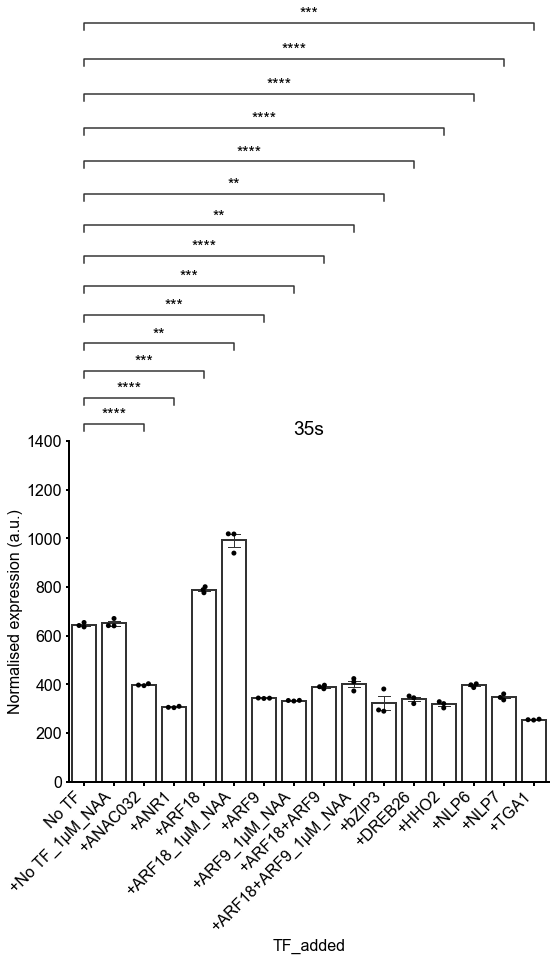

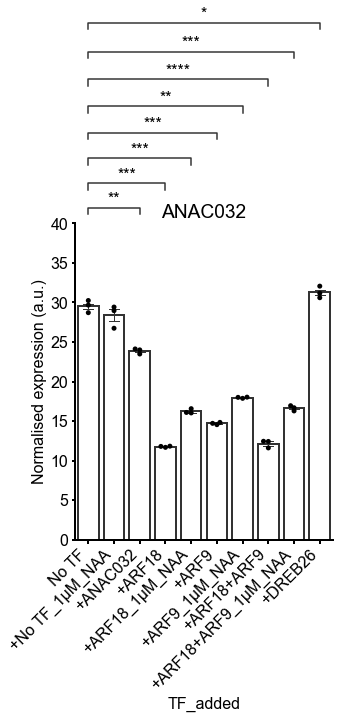

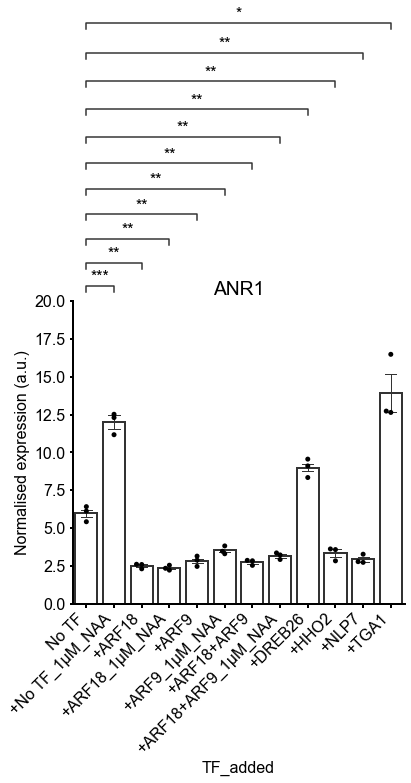

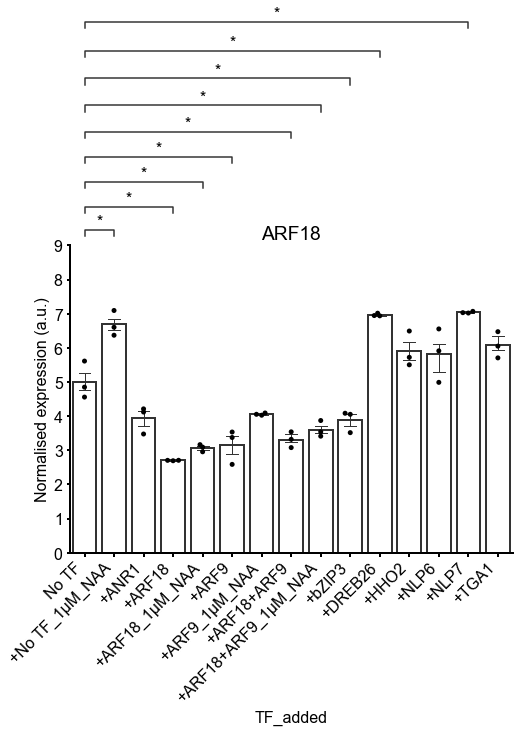

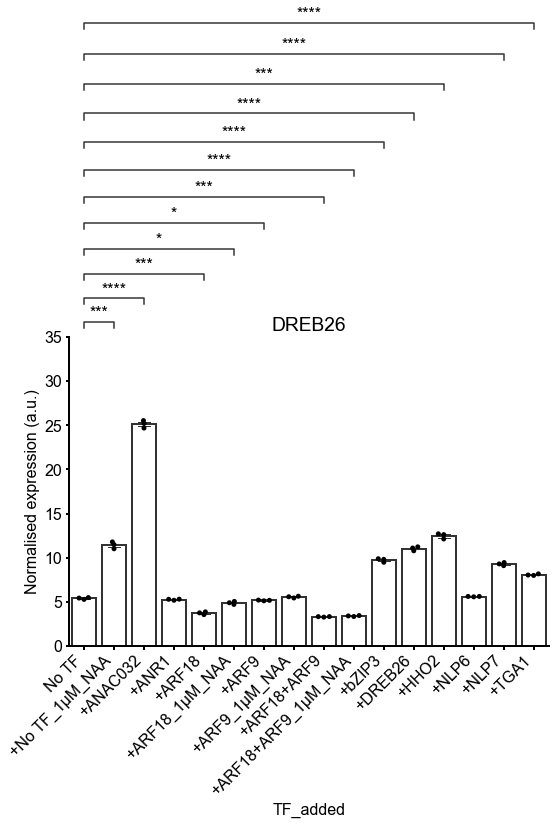

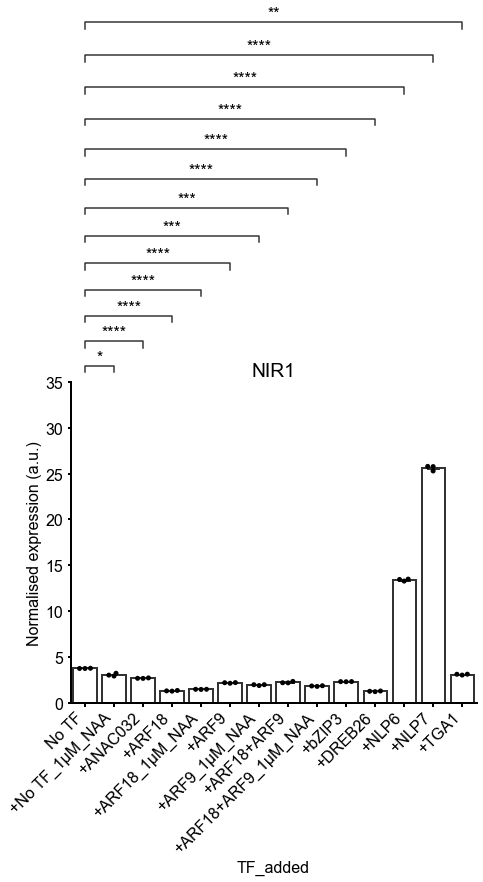

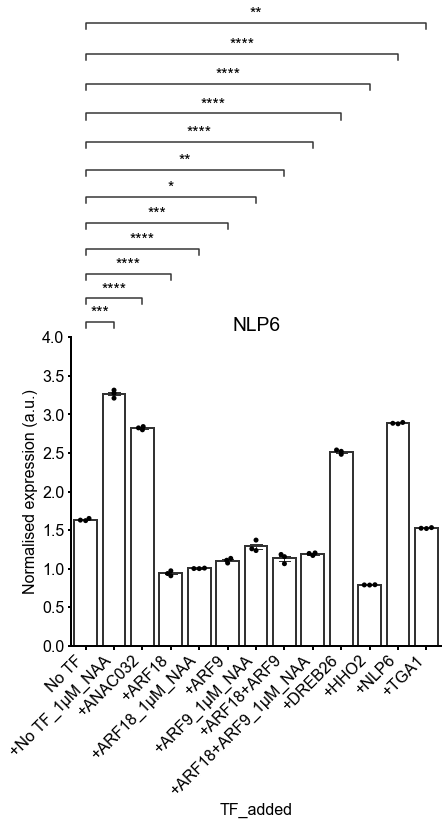

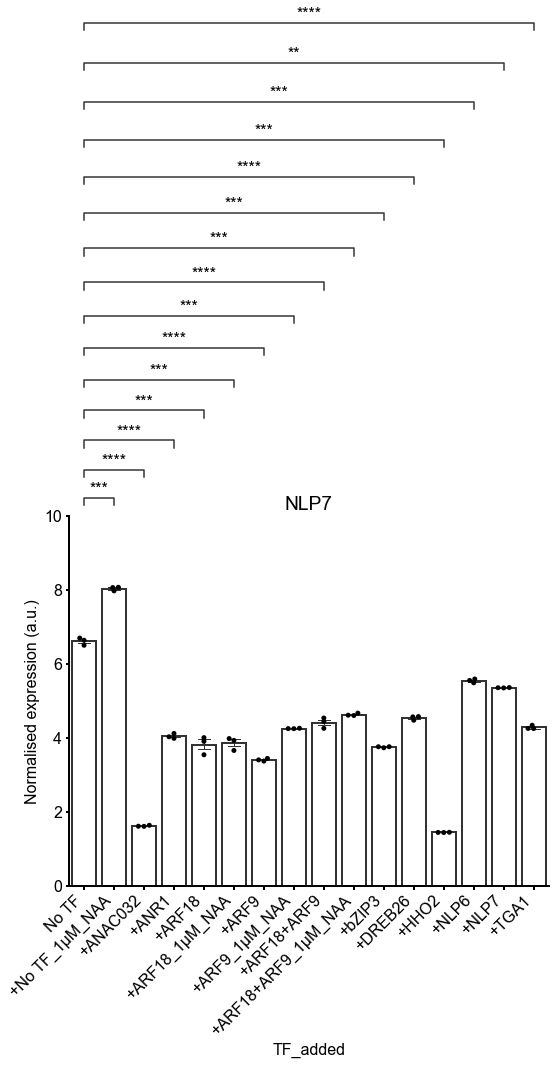

In [35]:
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
rcParams['font.size'] = 16
for prom in prom_names:
    if prom == 'NOS' or prom == 'STAP4':
        pass
    else:
        df1 = luminescence_raw_df[luminescence_raw_df.Promoter == prom].sort_values("TF_added", ascending=False)
        df2 = luminescence_raw_df[luminescence_raw_df.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        df2['TF_added'] = 'pSTAP4 no TF'
        df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+No TF_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "No TF":
                pass
            else:
                box_pairs.append(('No TF',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))
        box_pairs_all_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v
                

        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) < 3:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf/2)),10))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
            sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            add_stat_annotation(
                fig,
                data=df,
                x='TF_added',
                y='corrected_luminescence',
                order=order,
                box_pairs=list(box_pairs_significant.keys()),
                text_format="star",
                loc="outside",
                verbose=2,
                perform_stat_test=False,
                pvalues=list(box_pairs_significant.values()),
                #test_short_name="Dunn",
            )
            # change axes labels
            plt.ylabel('Normalised expression (a.u.)')
            #add title
            plt.title(prom)
            #make xticks diagonal
            plt.xticks(rotation=45, ha='right')
            #plt.xlabel(x_label)
            # tight layout
            plt.tight_layout()
            # save figure
            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/scatter{prom}.pdf',
                format="pdf",
                bbox_inches="tight",
            )
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

('No TF', '+No TF_1μM_NAA')
('No TF', '+ANAC032')
('No TF', '+ANR1')
('No TF', '+ARF18')
('No TF', '+ARF18_1μM_NAA')
('No TF', '+ARF9')
('No TF', '+ARF9_1μM_NAA')
('No TF', '+ARF18+ARF9')
('No TF', '+ARF18+ARF9_1μM_NAA')
('No TF', '+bZIP3')
('No TF', '+DREB26')
('No TF', '+HHO2')
('No TF', '+NLP6')
('No TF', '+NLP7')
('No TF', '+TGA1')
35s
['No TF', '+No TF_1μM_NAA', '+ANAC032', '+ANR1', '+ARF18', '+ARF18_1μM_NAA', '+ARF9', '+ARF9_1μM_NAA', '+ARF18+ARF9', '+ARF18+ARF9_1μM_NAA', '+bZIP3', '+DREB26', '+HHO2', '+NLP6', '+NLP7', '+TGA1']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

No TF v.s. +No TF_1μM_NAA: Custom statistical test, P_val:1.000e+00
No TF v.s. +ANAC032: Custom statistical test, P_val:1.000e+00
No TF v.s. +ANR1: Custom statistical test, P_val:7.348e-01
No TF v.s. +ARF18: Custom statistical test, P_val:1.000e+00
No TF v.s. +ARF18_1μM_NAA: Custom statistical t

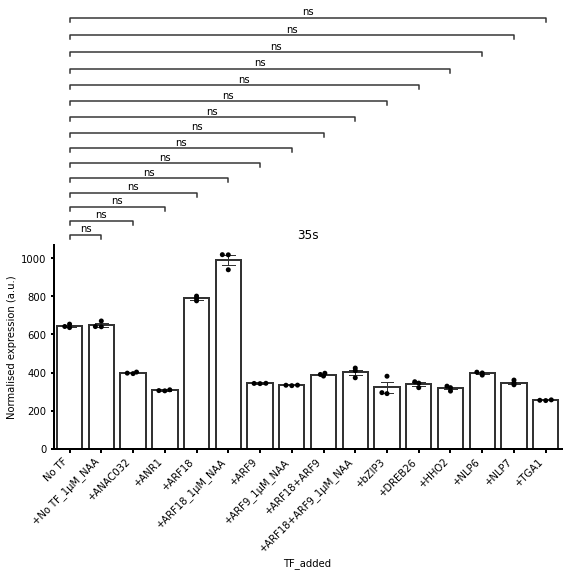

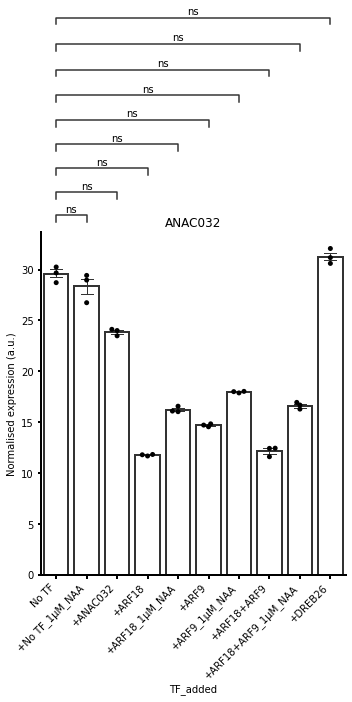

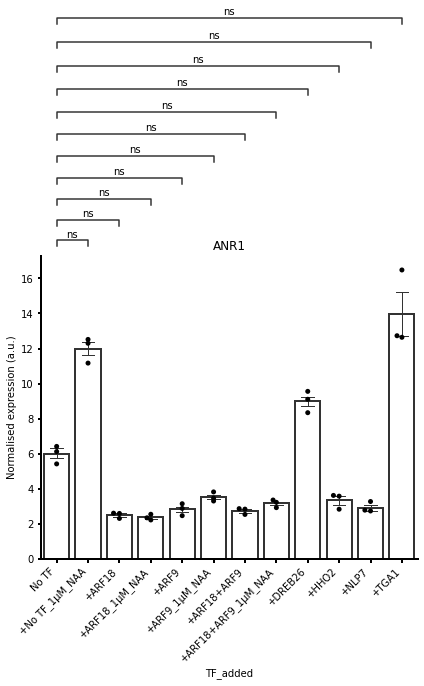

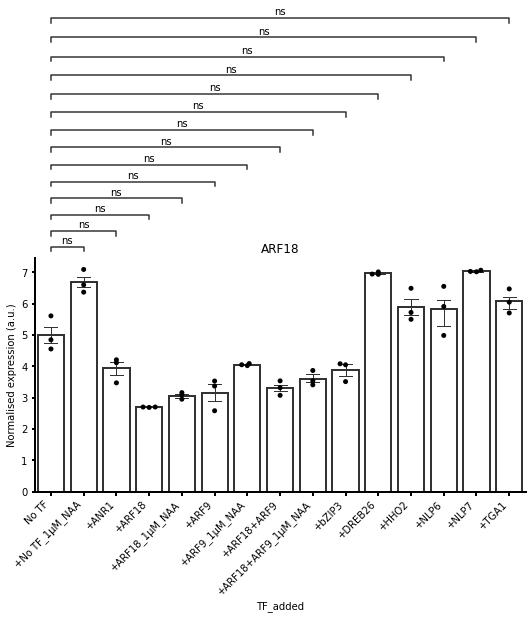

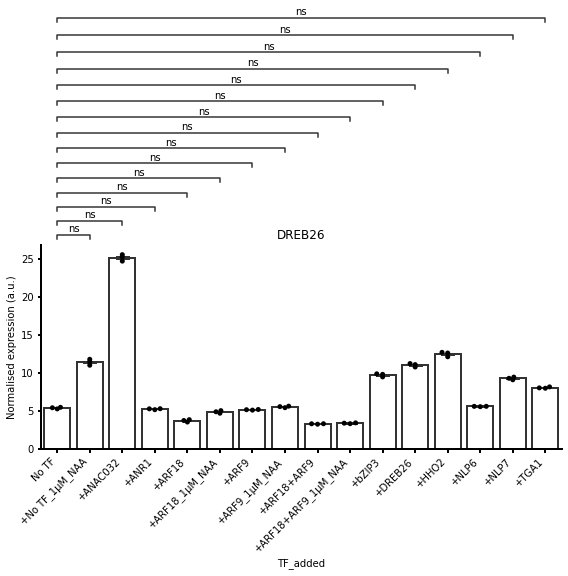

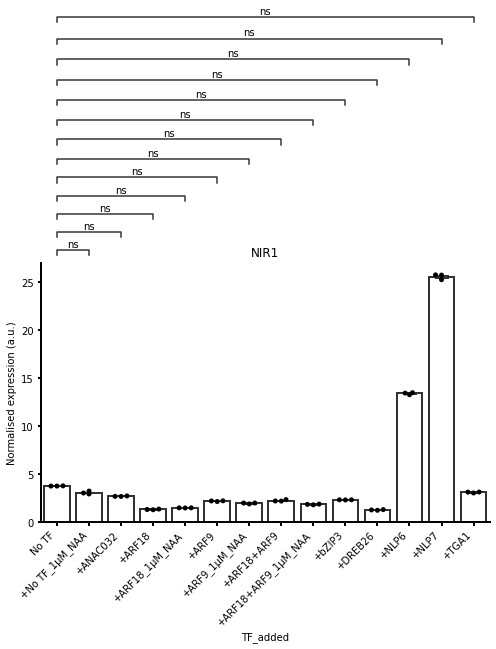

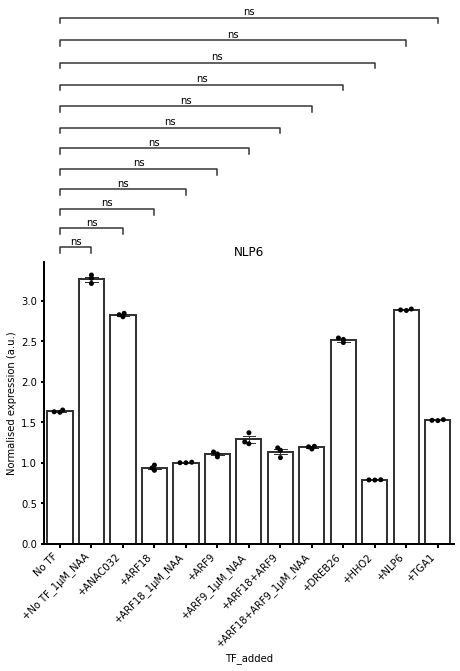

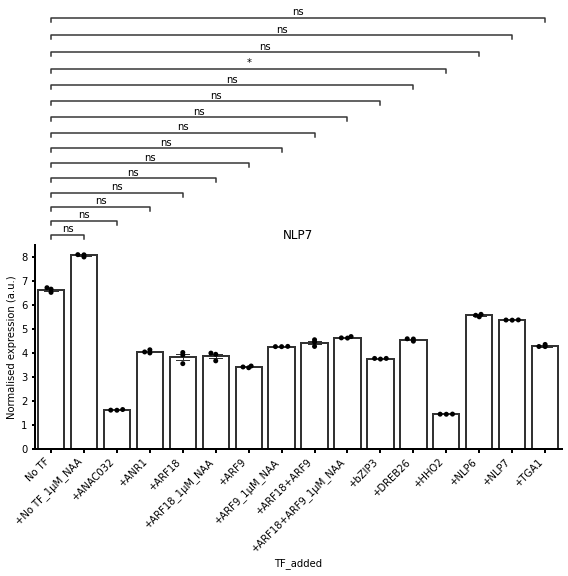

In [42]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# #set matplotlib default parameters
# rcParams['xtick.major.width'] = 2
# rcParams['ytick.major.width'] = 2
# rcParams['axes.linewidth'] = 2
# #rcParams['lines.linewidth'] = 2
# #remove top and right lines
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# for prom in prom_names:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df1 = luminescence_raw_df[luminescence_raw_df.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df[luminescence_raw_df.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs_orig =  df.TF_added.unique()
#         TF_order = ['No TF','+No TF_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
#         #sort based on custom order
#         TFs = []
#         for i in range(len(TF_order)):
#             if TF_order[i] in TFs_orig:
#                 TFs+=[TF_order[i]]
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "No TF":
#                 pass
#             else:
#                 box_pairs.append(('No TF',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))
#         stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#         p_values = []
#         # populate the list of p_values according to the box_pairs
#         for pair in box_pairs:
#             print(pair)
#             # select p value for each pair
#             p = stat.loc[pair[0], pair[1]]
#             p_values.append(p)
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         # print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         # box_pairs_significant = {}
#         # for k,v in box_pairs_all_pvalues.items():
#         #     if v <0.05:
#         #         box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) < 3:
#             pass
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf-(length_tf/2)),10))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 perform_stat_test=False,
#                 pvalues=p_values,
#                 #test_short_name="Dunn",
#             )
#             # change axes labels
#             plt.ylabel('Normalised expression (a.u.)')
#             #add title
#             plt.title(prom)
#             #make xticks diagonal
#             plt.xticks(rotation=45, ha='right')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_dunns.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

### test normality

In [27]:
#returns test statistic, p-value
for name1 in prom_names:
    for name in names:
        print(name1,'{}: {}'.format(name, stats.shapiro(luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == name])))


NOS No TF: ShapiroResult(statistic=0.5251020193099976, pvalue=1.238369962131003e-09)
NOS +ARF18+ARF9_1μM_NAA: ShapiroResult(statistic=0.42579197883605957, pvalue=1.1550818079797409e-08)
NOS +ANAC032: ShapiroResult(statistic=0.510594367980957, pvalue=9.918662726704497e-07)
NOS +ARF18: ShapiroResult(statistic=0.4047103524208069, pvalue=7.545557956234461e-09)
NOS +NLP7: ShapiroResult(statistic=0.5255708694458008, pvalue=1.347020770481322e-06)
NOS +DREB26: ShapiroResult(statistic=0.45749348402023315, pvalue=2.2348542572103725e-08)
NOS +NLP6: ShapiroResult(statistic=0.4873144030570984, pvalue=6.232742180145578e-07)
NOS +No TF_1μM_NAA: ShapiroResult(statistic=0.4240517020225525, pvalue=1.1147569090041998e-08)
NOS +ARF18_1μM_NAA: ShapiroResult(statistic=0.40768206119537354, pvalue=8.007446261615314e-09)
NOS +ARF9_1μM_NAA: ShapiroResult(statistic=0.426181435585022, pvalue=1.1643177089126766e-08)
NOS +bZIP3: ShapiroResult(statistic=0.5426675081253052, pvalue=7.935528628877364e-06)
NOS +HHO2: Sh

#### not normal

In [28]:
#test variance
stats.levene(luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[0]], 
               luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[1]])

LeveneResult(statistic=0.7500323302253454, pvalue=0.39003444046528624)

In [29]:
test = luminescence_raw_df.groupby('Promoter')

In [26]:
test

# one-way ANOVA: scipy.stats.kruskal

In [30]:
for name in names:
    print(name)

No TF
+ARF18+ARF9_1μM_NAA
+ANAC032
+ARF18
+NLP7
+DREB26
+NLP6
+No TF_1μM_NAA
+ARF18_1μM_NAA
+ARF9_1μM_NAA
+bZIP3
+HHO2
+ARF9
+ARF18+ARF9
+TGA1
+ANR1


In [33]:
#luminescence anova
for promoter, value in test:
    if promoter == 'ANAC032':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'No TF'],
                value['corrected_luminescence'][value.TF_added == '+DREB26'],
                value['corrected_luminescence'][value.TF_added == '+ARF18'],
                value['corrected_luminescence'][value.TF_added == '+DREB26+ARF18']))
    if promoter == 'ANR1':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'No TF'],
                value['corrected_luminescence'][value.TF_added == '+ANR1'],
                value['corrected_luminescence'][value.TF_added == '+NLP7'],
                value['corrected_luminescence'][value.TF_added == '+ARF18'],
                value['corrected_luminescence'][value.TF_added == '+DREB26']))
    if promoter == 'ARF18':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'No TF'],
                value['corrected_luminescence'][value.TF_added == '+NLP7'],
                value['corrected_luminescence'][value.TF_added == '+DREB26']))
    if promoter == 'NLP6':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'No TF'],
                value['corrected_luminescence'][value.TF_added == '+ANR1'],                
                value['corrected_luminescence'][value.TF_added == '+ARF18'],
                value['corrected_luminescence'][value.TF_added == '+DREB26']))
    if promoter == 'DREB26':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'No TF'],                
                value['corrected_luminescence'][value.TF_added == '+ARF18'],
               ))
    if promoter == 'NLP7':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'No TF'],
                value['corrected_luminescence'][value.TF_added == '+ANR1'],
                value['corrected_luminescence'][value.TF_added == '+NLP7'],                
                value['corrected_luminescence'][value.TF_added == '+DREB26'],
                value['corrected_luminescence'][value.TF_added == '+ANAC032'],))
    
    if promoter == 'NIR1':
            
            print(promoter)     
            print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'No TF'],
                value['corrected_luminescence'][value.TF_added == '+NLP6+NLP7'],
                value['corrected_luminescence'][value.TF_added == '+NLP7'],                
                value['corrected_luminescence'][value.TF_added == '+DREB26'],
                value['corrected_luminescence'][value.TF_added == '+NLP6+NLP7+DREB26'],
                value['corrected_luminescence'][value.TF_added == '+NLP6']))        


ANAC032
F_onewayResult(statistic=nan, pvalue=nan)
ANR1
F_onewayResult(statistic=nan, pvalue=nan)
ARF18
F_onewayResult(statistic=40.01937389287316, pvalue=0.0003391341372945772)
DREB26
F_onewayResult(statistic=230.49353619618182, pvalue=0.00010974272494547394)
NIR1
F_onewayResult(statistic=nan, pvalue=nan)
NLP6
F_onewayResult(statistic=nan, pvalue=nan)
NLP7
F_onewayResult(statistic=2894.4800405139845, pvalue=2.869533821164409e-15)


In [34]:
df = luminescence_raw_df
#First rerun NIR1 it as a GLM
NIR1 = df[df.Promoter == 'NIR1']  
results = ols('corrected_luminescence ~ C(TF_added)', data=NIR1).fit()
results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     corrected_luminescence   R-squared:                       1.000
Model:                                OLS   Adj. R-squared:                  1.000
Method:                     Least Squares   F-statistic:                 1.402e+04
Date:                    Tue, 31 Aug 2021   Prob (F-statistic):           8.79e-50
Time:                            10:25:27   Log-Likelihood:                 46.169
No. Observations:                      42   AIC:                            -64.34
Df Residuals:                          28   BIC:                            -40.01
Df Model:                              13                                         
Covariance Type:                nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              2.6725      0.057     46.889      0.000       2.556       2.789
C(TF_added)[T.+ARF18]                 -1.3757      0.081    -17.067      0.000      -1.541      -1.211
C(TF_added)[T.+ARF18+ARF9]            -0.4480      0.081     -5.558      0.000      -0.613      -0.283
C(TF_added)[T.+ARF18+ARF9_1μM_NAA]    -0.8548      0.081    -10.605      0.000      -1.020      -0.690
C(TF_added)[T.+ARF18_1μM_NAA]         -1.2139      0.081    -15.059      0.000      -1.379      -1.049
C(TF_added)[T.+ARF9]                  -0.5065      0.081     -6.284      0.000      -0.672      -0.341
C(TF_added)[T.+ARF9_1μM_NAA]          -0.7392      0.081     -9.171      0.000      -0.904      -0.574
C(TF_added)[T.+DREB26]                -1.4291      0.081    -17.730      0.000      -1.594      -1.264
C(TF_added)[T.+NLP6]                  10.7312      0.081    133.133      0.000      10.566      10.896
C(TF_added)[T.+NLP7]                  22.9437      0.081    284.643      0.000      22.779      23.109
C(TF_added)[T.+No TF_1μM_NAA]          0.3711      0.081      4.603      0.000       0.206       0.536
C(TF_added)[T.+TGA1]                   0.4049      0.081      5.023      0.000       0.240       0.570
C(TF_added)[T.+bZIP3]                 -0.3744      0.081     -4.645      0.000      -0.540      -0.209
C(TF_added)[T.No TF]                   1.0707      0.081     13.283      0.000       0.906       1.236
==============================================================================
Omnibus:                       21.165   Durbin-Watson:                   2.495
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.401
Skew:                          -1.126   Prob(JB):                     1.54e-12
Kurtosis:                       8.101   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# #make anova table for NIR1
# aov_table = sm.stats.anova_lm(results, typ=2)
# aov_table

In [84]:
# #pairwise tukey posthoc test for NIR1

    
# mc = MultiComparison(NIR1['corrected_luminescence'], NIR1['TF_added'])
# mc_results = mc.tukeyhsd()
# print(mc_results)

In [35]:
rp.summary_cont(NIR1['corrected_luminescence'].groupby(NIR1['TF_added']))

,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ANAC032,3,2.672497,0.029077,0.016788,2.632198,2.712795
+ARF18,3,1.296804,0.037048,0.021389,1.245459,1.348150
+ARF18+ARF9,3,2.224534,0.087038,0.050251,2.103905,2.345162
+ARF18+ARF9_1μM_NAA,3,1.817686,0.036990,0.021356,1.766421,1.868951
+ARF18_1μM_NAA,3,1.458639,0.009698,0.005599,1.445198,1.472079
+ARF9,3,2.165986,0.039341,0.022714,2.111462,2.220510
+ARF9_1μM_NAA,3,1.933273,0.054292,0.031346,1.858028,2.008518
+DREB26,3,1.243391,0.035719,0.020623,1.193887,1.292896
+NLP6,3,13.403707,0.114452,0.066079,13.245084,13.562330


In [36]:
ANR1 = df[df.Promoter == 'ANR1']
rp.summary_cont(ANR1['corrected_luminescence'].groupby(ANR1['TF_added']))


,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ARF18,3,2.500881,0.169384,0.097794,2.266127,2.735636
+ARF18+ARF9,3,2.745408,0.183805,0.106120,2.490667,3.000149
+ARF18+ARF9_1μM_NAA,3,3.167196,0.222861,0.128669,2.858327,3.476065
+ARF18_1μM_NAA,3,2.367697,0.163689,0.094506,2.140835,2.594558
+ARF9,3,2.828769,0.342822,0.197929,2.353642,3.303897
+ARF9_1μM_NAA,3,3.528452,0.265029,0.153014,3.161141,3.895763
+DREB26,3,8.999824,0.614801,0.354956,8.147753,9.851894
+HHO2,3,3.342973,0.442702,0.255594,2.729419,3.956526
+NLP7,3,2.927457,0.298685,0.172446,2.513501,3.341413


In [37]:
for promoter, value in test:
    print('\033[1m' +promoter + '\033[0m')
    print(kruskal(data=df[df.Promoter == promoter], dv='corrected_luminescence', between='TF_added'))
    print('')

NOS
           Source  ddof1    H  p-unc
Kruskal  TF_added      0  0.0    NaN

STAP4


ZeroDivisionError: division by zero

In [38]:
#run Dunn's post-hoc test
#ANR1
sp.posthoc_dunn(df[df.Promoter == 'ANR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,+ARF18,+ARF18+ARF9,+ARF18+ARF9_1μM_NAA,+ARF18_1μM_NAA,+ARF9,+ARF9_1μM_NAA,+DREB26,+HHO2,+NLP7,+No TF_1μM_NAA,+TGA1,No TF
+ARF18,-1.000000,1.000000,1.0,1.000000,1.000000,1.0,0.440807,1.0,1.000000,0.145504,0.042886,1.000000
+ARF18+ARF9,1.000000,-1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.695926,0.241466,1.000000
+ARF18+ARF9_1μM_NAA,1.000000,1.000000,-1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
+ARF18_1μM_NAA,1.000000,1.000000,1.0,-1.000000,1.000000,1.0,0.187965,1.0,1.000000,0.056820,0.015323,0.555394
+ARF9,1.000000,1.000000,1.0,1.000000,-1.000000,1.0,1.000000,1.0,1.000000,1.000000,0.391898,1.000000
+ARF9_1μM_NAA,1.000000,1.000000,1.0,1.000000,1.000000,-1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
+DREB26,0.440807,1.000000,1.0,0.187965,1.000000,1.0,-1.000000,1.0,1.000000,1.000000,1.000000,1.000000
+HHO2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,-1.0,1.000000,1.000000,1.000000,1.000000
+NLP7,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,-1.000000,1.000000,0.555394,1.000000
+No TF_1μM_NAA,0.145504,0.695926,1.0,0.056820,1.000000,1.0,1.000000,1.0,1.000000,-1.000000,1.000000,1.000000


In [39]:
#NIR1 post-hoc test
sp.posthoc_dunn(df[df.Promoter == 'NIR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,+ANAC032,+ARF18,+ARF18+ARF9,+ARF18+ARF9_1μM_NAA,+ARF18_1μM_NAA,+ARF9,+ARF9_1μM_NAA,+DREB26,+NLP6,+NLP7,+No TF_1μM_NAA,+TGA1,+bZIP3,No TF
+ANAC032,-1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
+ARF18,1.0,-1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.079659,0.026063,1.000000,0.779393,1.0,0.223807
+ARF18+ARF9,1.0,1.000000,-1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
+ARF18+ARF9_1μM_NAA,1.0,1.000000,1.0,-1.000000,1.000000,1.0,1.000000,1.000000,0.639554,0.249735,1.000000,1.000000,1.0,1.000000
+ARF18_1μM_NAA,1.0,1.000000,1.0,1.000000,-1.000000,1.0,1.000000,1.000000,0.249735,0.089719,1.000000,1.000000,1.0,0.639554
+ARF9,1.0,1.000000,1.0,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
+ARF9_1μM_NAA,1.0,1.000000,1.0,1.000000,1.000000,1.0,-1.000000,1.000000,1.000000,0.639554,1.000000,1.000000,1.0,1.000000
+DREB26,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,-1.000000,0.033653,0.010308,0.522674,0.383209,1.0,0.100944
+NLP6,1.0,0.079659,1.0,0.639554,0.249735,1.0,1.000000,0.033653,-1.000000,1.000000,1.000000,1.000000,1.0,1.000000
+NLP7,1.0,0.026063,1.0,0.249735,0.089719,1.0,0.639554,0.010308,1.000000,-1.000000,1.000000,1.000000,1.0,1.000000
